## 指数関数型シナプスモデル

In [1]:
using Base: @kwdef
using Parameters: @unpack
using Plots
using LinearAlgebra
using Distributions, Random
using Dates
using TimeSeries
using MarketData
using Statistics

In [22]:
@kwdef struct Synapse_Parameter{FT}
    t_exc::FT = 2.0
    t_inh::FT = 5.0
end

@kwdef mutable struct Synapse{FT}
    param::Synapse_Parameter = Synapse_Parameter{FT}()
    Ne::UInt32 # Excニューロンの数
    Ni::UInt32 # Inhニューロンの数
    T::UInt32 # Time interval
    dt::Float32 # dt
    nt::UInt32 = round(Int64,T/dt) #time count
    g_syn::Matrix{FT} = zeros(Float32, Ne+Ni, nt)
    hr::Matrix{FT} = zeros(Float32, Ne+Ni, nt)
end 

function Synaptic_update!(variable::Synapse, param::Synapse_Parameter, spikes, t)
    @unpack Ne, Ni, T, dt, nt, g_syn, hr = variable
    @unpack t_exc, t_inh = param
    
    if Ne>0
        @inbounds @simd for i = 1:Ne
            ########### シナプス動態の導出 ###########
            hr[i,t+1] = (1 - (dt/t_exc)) * hr[i,t] + (1/(t_exc)^2) * spikes[i]
            g_syn[i,t+1] = (1 - (dt/t_exc)) * (g_syn[i,t]) + hr[i,t] * dt
            ########################################
        end
    end
    
    if Ni>0
        @inbounds @simd for i = Ne+1:Ne+Ni
            ########### シナプス動態の導出 ###########
            hr[i,t+1] = (1 - (dt/t_inh)) * hr[i,t] + (1/(t_inh)^2) * spikes[i]
            g_syn[i,t+1] = (1 - (dt/t_inh)) * (g_syn[i,t]) + hr[i,t] * dt
            ########################################
        end
    end
end

Synaptic_update! (generic function with 1 method)

In [23]:
dt, T = 1e-3, 30 # タイムステップ, シミュレーション時間 (sec)
nt = Int(T/dt) # シミュレーションの総ステップ

synapses_exc = Synapse{Float64}(Ne=1, Ni=0, T=T, dt=dt)

Synapse{Float64}(Synapse_Parameter{Float64}(2.0, 5.0), 0x00000001, 0x00000000, 0x0000001e, 0.001f0, 0x00007530, [0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0])

In [26]:
V_exc = 0
V_inh = -70
Er = -65

d = Normal(1.0, 0.5)

params_g = rand(d)

r_double= zeros(nt)
for t in 1:nt-1
    spike = ifelse(t == 1, 1, 0)
    Synaptic_update!(synapses_exc, synapses_exc.param, collect(spike)[:], t)
    r_double[t+1] = (synapses_exc.g_syn[t+1] .* (V_exc-Er) .* (params_g ./ (4*pi*((20)^2)))).*1e3
    #synapses_exc.hr[t] = synapses_exc.hr[t]
    #r_double[t+1] = r_double[t]*exp(-dt/tr) + hr[t]*dt
    #hr[t+1] = hr[t]*exp(-dt/td) + spike/(tr*td)
end 

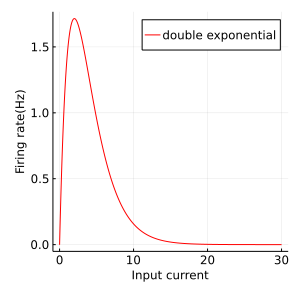

In [27]:
p1 = plot((1:nt)*dt, r_double, color="red",label="double exponential")
plot(p1 , guidefont=font(8),
xlabel = "Input current", 
ylabel = "Firing rate(Hz)",legend=true, size=(300,300))